In [ ]:
!pip install torch==1.4.0 torchvision==0.5.0

     |████████████████████████████████| 753.4MB 20kB/s 
     |████████████████████████████████| 4.0MB 60.4MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [ ]:
!pip install torch-geometric \
  torch-sparse==latest+cu101 \
  torch-scatter==latest+cu101 \
  torch-cluster==latest+cu101 \
  -f https://pytorch-geometric.com/whl/torch-1.4.0.html

Looking in links: https://pytorch-geometric.com/whl/torch-1.4.0.html
     |████████████████████████████████| 184kB 5.6MB/s 
     |████████████████████████████████| 15.2MB 23.2MB/s 
     |████████████████████████████████| 10.6MB 68.0MB/s 
     |████████████████████████████████| 14.5MB 590kB/s 
     |████████████████████████████████| 235kB 16.4MB/s 
     |████████████████████████████████| 2.2MB 16.5MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.6.1-cp36-none-any.whl size=308552 sha256=de569b3d596abe9cc714a41100cdb07ec430667c73e68d4d5e115fad67fc96f3
  Stored in directory: /root/.cache/pip/wheels/e6/25/ea/3d71d2088dccc63214fa59259dcc598ded4150a5f8b41d84ff
Successfully built torch-geometric


In [ ]:
import torch; print(torch.__version__)

1.4.0


In [ ]:
 !python -c "import torch; print(torch.__version__)"

1.4.0


In [ ]:
!python -c "import torch; print(torch.version.cuda)"

10.1


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np
import torch
import torch.optim as optim
from torchvision.datasets import MNIST
import multiprocessing

import numpy as np
import scipy as sp
from skimage.segmentation import slic, mark_boundaries
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
NP_TORCH_FLOAT_DTYPE = np.float32
NP_TORCH_LONG_DTYPE = np.int64


In [ ]:
import torch
import networkx as nx

%matplotlib inline

In [ ]:
#A = torch.tensor( nx.adjacency_matrix(G).todense(), dtype=torch.float32 )### graph to adjacency conversion



In [ ]:
class CNNfeaturemap(torch.nn.Module):
  def __init__(self):
        super(CNNfeaturemap, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=1,padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=1,padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=1,padding=1)
        self.conv4 = nn.Conv2d(32, 16, 3, stride=1,padding=1)
        self.conv5 = nn.Conv2d(16, 8, 3, stride=1,padding=1)
        self.conv6 = nn.Conv2d(8, 3, 3, stride=1,padding=1)
        self.conv7 = nn.Conv2d(3, 1, 3, stride=1,padding=1)
        #self.conv1d= m = nn.Conv1d(924, 784, 1, stride=1)
        #self.fc2 = nn.Linear(924, 784)

  def forward(self, x):
        x1 = F.relu(self.conv1(x))
        #print(x1.size())
        x2 = F.relu(self.conv2(x1))
        x3 = F.relu(self.conv3(x2))
        x4 = F.relu(self.conv4(x3))
        x5 = F.relu(self.conv5(x4))
        x6 = F.relu(self.conv6(x5))
        x7 = F.relu(self.conv7(x6))
               
        return x7


class Encoder(torch.nn.Module):                        ######### aim is to create feature vector for GNN
  def __init__(self):       ###### Basic AE advanced VAE
        super(Encoder, self).__init__()                   ###### Adaptive average pooling  and then flattened vector should be the output
        self.conv1 = nn.Conv2d(1, 32, 3, stride=2,padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2,padding=1)
        self.conv3 = nn.Conv2d(64, 32, 3, stride=1,padding=1)

        self.conv4 = nn.Conv2d(32, 16, 3, stride=1,padding=1)
        self.conv5 = nn.Conv2d(16, 16, 3, stride=1,padding=1)
        self.upsample1=torch.nn.Upsample(scale_factor=2, mode='nearest')
        self.upsample2=torch.nn.Upsample(scale_factor=2, mode='nearest')
        self.upsample3=torch.nn.Upsample(scale_factor=4, mode='nearest')
        
        

  def forward(self, x):
        x1 = F.relu(self.conv1(x))
        #print(x1.size())
        x2 = F.relu(self.conv2(x1))
        x3 = F.relu(self.upsample1(self.conv3(x2)))
        x4 = F.relu(self.upsample2(self.conv4(x3)))
        x5 = F.relu(self.conv5(x4))
        x6=torch.nn.AdaptiveAvgPool2d(7)(x5)
        x6=self.upsample3(x6)
        x7=torch.nn.Flatten()(x6)
        
               
        return x7

class Decoder(torch.nn.Module):            ######### aim is to create Adjacency matrix and Feature vector
  def __init__(self ):                     ###### inner product is adjacency matrix
        super(Decoder, self).__init__()                   
  
  def forward(self, x):
        A=x@x.t()
        return A,x
#p=torch.zeros(784,16)
#ad,xt=Decoder()(p)
#print(ad.size(),xt.size())



class GINConv(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear = torch.nn.Linear(16, 1)

    def forward(self, A, X):
        """
        Params
        ------
        A [batch x nodes x nodes]: adjacency matrix
        X [batch x nodes x features]: node features matrix
        
        Returns
        -------
        X' [batch x nodes x features]: updated node features matrix
        """
        X = self.linear(X + A @ X)
        X = torch.nn.functional.relu(X)
        
        return X




In [ ]:
def normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x 
    """
    #min_val = np.min(x)
    max_val = np.max(x)
    x = x / max_val
    return x


class SCG(torch.nn.Module):
    def __init__(self):
        super(SCG, self).__init__()
        self.cnnfeaturemap=CNNfeaturemap()
        self.encoder=Encoder()
        self.decoder=Decoder()
        self.gin=GINConv()

        

    def forward(self, x):
        cnf=self.cnnfeaturemap(x)
        #print('cnf',cnf.size())
        enc=self.encoder(cnf)
        #enc1=enc.squeeze()
        #print(enc.size())
        enc=torch.reshape(enc,(784,16))
        adj,featurematrix=self.decoder(enc)
        #print(adj.size(),featurematrix.size())
        fmatrix=self.gin(adj,featurematrix)
        fmatrix=F.sigmoid(fmatrix)
        fmatrix=torch.reshape(fmatrix,(1,1,28,28))


        
        return fmatrix,x,enc,adj
#p=torch.zeros(1,1,28,28)
#q=torch.zeros(784,784)
#f=SCG()(p)
#print(f.size())






from torch.utils.data import TensorDataset, DataLoader
   
####################     Data precessing mnist##############
dset_folder = "./mnist"
channels = 16
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('CUDA availability:', torch.cuda.is_available())


print("Reading dataset")
dset = MNIST(dset_folder,download=True)
def normalise_dataset(data):
  return np.array([normalize(xi) for xi in data])
imgs = dset.data.unsqueeze(-1).numpy().astype(np.float64)
imgs=imgs[:5000,:,:,0]
imgs=normalise_dataset(imgs)
labels = dset.targets.numpy()

tensor_x = torch.Tensor(imgs) # transform to torch tensor
tensor_y = torch.Tensor(imgs)

my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader = DataLoader(my_dataset,batch_size=1, shuffle=True) # create your dataloader

def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)




model = SCG()
#model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)





##############train and test#############
#for epoch in range(1, 1000):
    
#    img,loss,x,out=train(epoch,imgs)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" )
for epoch in range(10):
    # Training
    for local_batch, local_labels in my_dataloader:
        # Transfer to GPU
        optimizer.zero_grad()
        local_batch, local_labels = local_batch, local_labels#local_batch.to(torch.device('cuda')), local_labels.to(torch.device('cuda'))#local_batch.cuda(), local_labels.cuda()#local_batch.to('cuda'), local_labels.to('cuda')
        #i,mu,logvar,gamm,adj = model(local_batch)
        #print(local_batch.size())
        local_batch=torch.reshape(local_batch,(local_batch.shape[0],1,local_batch.shape[1],local_batch.shape[2]))
        out,inp,enc,adj = model(local_batch)
        loss = torch.nn.functional.mse_loss(out,local_batch)
        #loss=torch.nn.BCELoss()(out,local_batch)
        
        
        loss.backward()
        optimizer.step()

    print('Epoch: {:03d}, Loss: {:.4f}'.format(epoch,loss))
    







CUDA availability: True
Reading dataset


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...



Done!


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 000, Loss: 0.2259
Epoch: 001, Loss: 0.2230
Epoch: 002, Loss: 0.2323
Epoch: 003, Loss: 0.2279
Epoch: 004, Loss: 0.2296
Epoch: 005, Loss: 0.2309
Epoch: 006, Loss: 0.2405
Epoch: 007, Loss: 0.2333
Epoch: 008, Loss: 0.2316
Epoch: 009, Loss: 0.2390


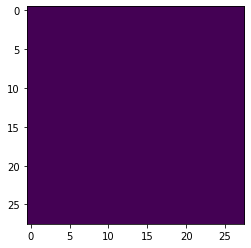

In [ ]:
plt.imshow(np.squeeze(out.detach().numpy()))

In [ ]:
#enc=enc.detach().numpy()
print(enc.shape)
enc=np.reshape(enc,(28,28,16))

(784, 16)


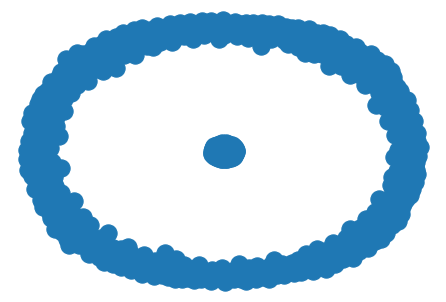

In [ ]:
adj=adj.detach().numpy()
adj=nx.from_numpy_matrix(adj)
H=nx.Graph(adj) 
nx.draw(H)
plt.show()

1.0


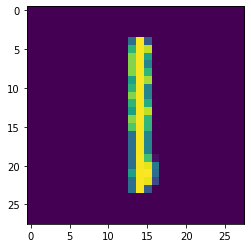

In [ ]:
plt.imshow(np.squeeze(inp.detach().numpy()))
print(np.max(inp.numpy()))